# Graph Neural Network based FEC Decoding

In this notebook, you will learn about graph neural network (GNN)-based decoding of BCH codes. 

This code is provided as supplementary material to the paper [[Graph Neural Networks for Channel Decoding]](https://arxiv.org/pdf/2207.14742.pdf). 
If you in any way use this code for research that results in publications, please cite it appropriately. 

The idea is to let a neural network (NN) learn a generalized message passing algorithm over a given graph that represents the forward error correction (FEC) code
structure by replacing node and edge message updates with trainable functions.
A similar decoding approach based on GNNs can be found in [2].

Note that some simulations in this notebook require severe simulation time, in particular, for the GNN training.
Please keep in mind that each cell in this notebook already contains the pre-computed outputs and no new execution is required to understand the examples.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Defining the End-to-End Model](#Define-the-End-to-end-Model)
* [Weighted BP](#Weighted-BP)
* [GNN-based Decoding](#GNN-based-Decoding)
* [Training](#Training)
* [Final Performance](#Final-Performance)
* [References](#References)

## GPU Configuration and Imports

In [1]:
# Import TensorFlow and NumPy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 1 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 1 used.


Please ensure that the [Sionna link-level simulator](https://nvlabs.github.io/sionna/) is installed.

In [3]:
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, GaussianPriorSource
from sionna.utils import BinarySource, ebnodb2no, BitwiseMutualInformation, hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER
from sionna.mapping import Mapper, Demapper
from sionna.channel import AWGN
from sionna.fec.ldpc import LDPCBPDecoder

from tensorflow.keras.layers import Dense, Layer

## Define the End-to-end Model

We define an end-to-end transmission model to evaluate the trained decoders and the baseline in the same setup.

In [4]:
class E2EModel(tf.keras.Model):
    def __init__(self, pcm, decoder):
        super().__init__()
        self._pcm = pcm
        self._n = pcm.shape[1]
        self._k = self._n - pcm.shape[0]
        self._encoder = LinearEncoder(pcm, is_pcm=True)
       
        self._binary_source = BinarySource()

        self._num_bits_per_symbol = 2 # at the moment only QPSK is supported
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._channel = AWGN()        
        self._decoder = decoder
    
    @tf.function()
    def call(self, batch_size, ebno_db):

        # calculate noise variance
        if self._decoder is not None:
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._k/self._n)
        else: #for uncoded BPSK the rate is 1
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, 1)
            
        # draw random info bits to transmit
        b = self._binary_source([batch_size, self._k])
        c = self._encoder(b)

        # zero padding to support odd codeword lengths
        if self._n%2==1:
            c_pad = tf.concat([c, tf.zeros([batch_size, 1])], axis=1)
        else: # no padding
            c_pad = c   

        # map to symbols     
        x = self._mapper(c_pad)

        # transmit over AWGN channel        
        y = self._channel([x, no])

        # demap to LLRs
        llr = self._demapper([y, no])
        
        # remove filler bits
        if self._n%2==1:
            llr = llr[:,:-1]

        # and decode
        if self._decoder is not None:
            llr = self._decoder(llr)
          
        return c, llr

We now load the parity-check matrix of the code. This line can be replaced by other codes as well, however, please keep in mind that the hyperparameters of the decoder (and its training) must be adjusted accordingly.

In [5]:
# load the parity-check matrix of the code
pcm, k, n, coderate = load_parity_check_examples(pcm_id=1, verbose=True)


n: 63, k: 45, coderate: 0.714


Let us define the simulation parameters.

In [26]:
ber_plot = PlotBER("GNN-based Decoding Results")
ebno_db_min = 2.0
ebno_db_max = 9.0
ebno_dbs = np.arange(ebno_db_min,ebno_db_max+1)

mc_iters = 100
mc_batch_size = 10000
num_target_block_errors = 2000

Simulate the uncoded baseline first.

In [27]:
e2e_uncoded = E2EModel(pcm, None)
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=mc_batch_size,
                  num_target_block_errors=num_target_block_errors,
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 3.7433e-02 | 9.1480e-01 |       23583 |      630000 |         9148 |       10000 |         0.2 |reached target block errors
      3.0 | 2.2829e-02 | 7.6690e-01 |       14382 |      630000 |         7669 |       10000 |         0.0 |reached target block errors
      4.0 | 1.2676e-02 | 5.4700e-01 |        7986 |      630000 |         5470 |       10000 |         0.0 |reached target block errors
      5.0 | 5.9667e-03 | 3.1730e-01 |        3759 |      630000 |         3173 |       10000 |         0.0 |reached target block errors
      6.0 | 2.4198e-03 | 1.4150e-01 |        3049 |     1260000 |         2830 |       20000 |         0.0 |reached target block errors
      7.0 | 7.6698e-04 | 4.7220e-02 |        2416 |     3150000 |

And the BP decoding baseline. Please note that, BP decoding is not necessarily a good choice to decode BCH codes due to their high-density graph structure. 

In [28]:
bp_decoder = LDPCBPDecoder(pcm, num_iter=20, hard_out=False)
e2e_bp = E2EModel(pcm, bp_decoder)
ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=mc_batch_size,
                  num_target_block_errors=num_target_block_errors,
                  legend=f"BP {e2e_bp._decoder.num_iter.numpy()} iter.",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.0129e-02 | 8.0420e-01 |       37881 |      630000 |         8042 |       10000 |         1.2 |reached target block errors
      3.0 | 3.3086e-02 | 4.9720e-01 |       20844 |      630000 |         4972 |       10000 |         0.1 |reached target block errors
      4.0 | 1.3903e-02 | 2.1760e-01 |        8759 |      630000 |         2176 |       10000 |         0.1 |reached target block errors
      5.0 | 4.3762e-03 | 6.3000e-02 |       11028 |     2520000 |         2520 |       40000 |         0.3 |reached target block errors
      6.0 | 9.5099e-04 | 1.3006e-02 |        9586 |    10080000 |         2081 |      160000 |         1.2 |reached target block errors
      7.0 | 1.3116e-04 | 1.7950e-03 |        8263 |    63000000 |

## Weighted BP

The BP decoder can be further optimized by applying the concept of *weighted* BP [3].
See [Sionna example notebook](https://nvlabs.github.io/sionna/examples/Weighted_BP_Algorithm.html) for further details.

Note that the model below is only used to train the WBP decoder, the evaluation is done by using the previously defined e2e-model.

In [9]:
class WeightedBP(tf.keras.Model):
    """System model for BER simulations of weighted BP decoding.

    This model uses `GaussianPriorSource` to mimic the LLRs after demapping of
    QPSK symbols transmitted over an AWGN channel.

    Parameters
    ----------
        pcm: ndarray
            The parity-check matrix of the code under investigation.

        num_iter: int
            Number of BP decoding iterations.

    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.

        ebno_db: float or tf.float
            A float defining the simulation SNR.

    Output
    ------
        (u, u_hat, loss):
            Tuple:

        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.

        loss: tf.float32
            Binary cross-entropy loss between `u` and `u_hat`.
    """
    def __init__(self, pcm, num_iter=5):
        super().__init__()

        # init components
        self.decoder = LDPCBPDecoder(pcm,
                                     num_iter=1, # iterations are done via outer loop (to access intermediate results for multi-loss)
                                     keep_state=True, # decoder stores internal messages after call
                                     hard_out=False, # we need to access soft-information
                                     cn_type="boxplus",
                                     trainable=True) # the decoder must be trainable, otherwise no weights are generated

        # used to generate llrs during training (see example notebook on all-zero codeword trick)
        self._llr_source = GaussianPriorSource()
        self._num_iter = num_iter

        self._n = pcm.shape[1]
        self._coderate = 1 - pcm.shape[0]/pcm.shape[1]
        self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):
        #batch_size = tf.constant(batch_size, dtype=tf.int32)
        #ebno_db = tf.constant(ebno_db, dtype=tf.float32)
        noise_var = ebnodb2no(ebno_db,
                              num_bits_per_symbol=2, # QPSK
                              coderate=self._coderate)

        # all-zero CW to calculate loss / BER
        c = tf.zeros([batch_size, self._n])

        # Gaussian LLR source
        llr = self._llr_source([[batch_size, self._n], noise_var])

        # --- implement multi-loss as proposed by Nachmani et al. [1]---
        loss = 0
        for i in range(self._num_iter):
            c_hat = self.decoder(llr) # perform one decoding iteration; decoder returns soft-values
            loss += self._bce(c, c_hat)  # add loss after each iteration

        loss /= self._num_iter # scale loss by number of iterations

        self.decoder.reset_state() # prepare decoder for next batch of codewords

        return c, c_hat, loss

    def train_wbp(self, train_param):

        assert len(train_param["batch_size"])==len(train_param["train_iter"]),\
                        "batch_size must have same lengths as train_iter"

        assert len(train_param["batch_size"])==\
               len(train_param["learning_rate"]),\
                "batch_size must have same lengths as learning_rate"

        assert len(train_param["batch_size"])==len(train_param["ebno_train"]),\
                        "batch_size must have same lengths as ebno_train"

        # bmi is used as metric to evaluate the intermediate results
        bmi = BitwiseMutualInformation()

        for idx, batch_size in enumerate(train_param["batch_size"]):

            optimizer = tf.keras.optimizers.Adam(train_param["learning_rate"][idx])

            for it in range(train_param["train_iter"][idx]):
                with tf.GradientTape() as tape:
                    b, llr, loss = self(batch_size,
                                        train_param["ebno_train"][idx])

                grads = tape.gradient(loss, self.trainable_variables)
                grads = tf.clip_by_value(grads,
                                         -train_param["clip_value_grad"],
                                         train_param["clip_value_grad"],
                                         name=None)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))

                # calculate and print intermediate metrics
                # only for information, this has no impact on the training
                if it%50==0: # evaluate every 10 iterations
                    b, llr, loss = self(train_param["batch_size_val"],
                                        train_param["ebno_val"])
                    b_hat = hard_decisions(llr) # hard decided LLRs first
                    ber = compute_ber(b, b_hat)
                    # and print results
                    mi = bmi(b, llr).numpy() # calculate bit-wise mutual information
                    l = loss.numpy() # copy loss to numpy for printing
                    print(f"Iter: {it} loss: {l:3f} ber: {ber:.4f} bmi: {mi:.3f}".format())
                    bmi.reset_states() # reset the BMI metric

In [29]:
model_wbp = WeightedBP(pcm=pcm, num_iter=10) # model is only used for training

In [30]:
train_param = {
    "batch_size" : [2000, 2000, 2000],
    "train_iter" : [300, 1000, 1000],
    "learning_rate" : [1e-2, 1e-3, 1e-3],
    "ebno_train" : [5., 5., 6.],
    "ebno_val" : 7., # validation SNR during training
    "batch_size_val" : 2000,
    "clip_value_grad" : 10, 
}

In [31]:
model_wbp.train_wbp(train_param)

Iter: 0 loss: 0.002307 ber: 0.0002 bmi: 0.998
Iter: 10 loss: 0.003557 ber: 0.0002 bmi: 0.998
Iter: 20 loss: 0.002751 ber: 0.0002 bmi: 0.998
Iter: 30 loss: 0.002278 ber: 0.0001 bmi: 0.999
Iter: 40 loss: 0.001955 ber: 0.0001 bmi: 1.000
Iter: 50 loss: 0.003210 ber: 0.0001 bmi: 0.999
Iter: 60 loss: 0.002282 ber: 0.0001 bmi: 0.999
Iter: 70 loss: 0.002325 ber: 0.0001 bmi: 0.998
Iter: 80 loss: 0.002410 ber: 0.0002 bmi: 0.998
Iter: 90 loss: 0.002197 ber: 0.0001 bmi: 0.999
Iter: 100 loss: 0.002448 ber: 0.0002 bmi: 0.998
Iter: 110 loss: 0.001762 ber: 0.0001 bmi: 0.999
Iter: 120 loss: 0.000913 ber: 0.0000 bmi: 1.000
Iter: 130 loss: 0.002668 ber: 0.0001 bmi: 0.999
Iter: 140 loss: 0.001393 ber: 0.0000 bmi: 1.000
Iter: 150 loss: 0.002041 ber: 0.0002 bmi: 0.999
Iter: 160 loss: 0.001677 ber: 0.0001 bmi: 0.999
Iter: 170 loss: 0.001489 ber: 0.0002 bmi: 0.999
Iter: 180 loss: 0.001689 ber: 0.0001 bmi: 0.999
Iter: 190 loss: 0.000855 ber: 0.0000 bmi: 1.000
Iter: 200 loss: 0.001044 ber: 0.0001 bmi: 0.999
Ite

In [32]:
# generate new decoder object (with 20 iterations)
bp_decoder_wbp = LDPCBPDecoder(pcm, num_iter=20, hard_out=False, trainable=True)

# copy weights from trained decoder
bp_decoder_wbp.set_weights(model_wbp.decoder.get_weights()) 
e2e_wbp = E2EModel(pcm, bp_decoder_wbp)

# and evaluate the performance
ber_plot.simulate(e2e_wbp,
                  ebno_dbs=ebno_dbs,
                  batch_size=mc_batch_size*10, #increased bs for higher gpu load
                  num_target_block_errors=num_target_block_errors,
                  legend=f"Weighted BP {e2e_wbp._decoder.num_iter.numpy()} iter.",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.5982e-02 | 9.8318e-01 |      415688 |     6300000 |        98318 |      100000 |         1.2 |reached target block errors
      3.0 | 4.3031e-02 | 8.7357e-01 |      271094 |     6300000 |        87357 |      100000 |         0.4 |reached target block errors
      4.0 | 1.8084e-02 | 4.3284e-01 |      113932 |     6300000 |        43284 |      100000 |         0.4 |reached target block errors
      5.0 | 3.5573e-03 | 8.6290e-02 |       22411 |     6300000 |         8629 |      100000 |         0.4 |reached target block errors
      6.0 | 3.7058e-04 | 9.2333e-03 |        7004 |    18900000 |         2770 |      300000 |         1.2 |reached target block errors
      7.0 | 2.9743e-05 | 9.6000e-04 |        3935 |   132300000 |

### GNN-based Decoding

We now define the GNN for iterative decoding.

In [14]:
class MLP(Layer):
    """Simple MLP layer.

    Parameters
    ----------
    units : List of int
        Each element of the list describes the number of units of the
        corresponding layer.

    activations : List of activations
        Each element of the list contains the activation to be used
        by the corresponding layer.

    use_bias : List of booleans
        Each element of the list indicates if the corresponding layer
        should use a bias or not.
    """
    def __init__(self, units, activations, use_bias):
        super().__init__()
        self._num_units = units
        self._activations = activations
        self._use_bias = use_bias

    def build(self, input_shape):
        self._layers = []
        for i, units in enumerate(self._num_units):
            self._layers.append(Dense(units,
                                      self._activations[i],
                                      use_bias=self._use_bias[i]))

    def call(self, inputs):
        outputs = inputs
        for layer in self._layers:
            outputs = layer(outputs)
        return outputs

class GNN_BP(Layer):
    """GNN-based BP Decoder

    Parameters
    ---------
    H : [num_ch, num_vn], numpy.array
        The parity check matrix.

    num_embed_dims: int
        Number of dimensions of the vertex embeddings.

    num_msg_dims: int
        Number of dimensions of a message.

    num_hidden_units: int
        Number of hidden units of the MLPs used to compute
        messages and to update the vertex embeddings.

    num_mlp_layers: int
        Number of layers of the MLPs used to compute
        messages and to update the vertex embeddings.

    num_iter: int
        Number of iterations.

    reduce_op: str
        A string defining the vertex aggregation function.
        Currently, "mean" and "sum" is supported.

    activation: str
        A string defining the activation function of the hidden MLP layers to
        be used. Defaults to "relu".

    output_all_iter: Bool
        Indicates if the LLRs of all iterations should be returned as list
        or if only the LLRs of the last iteration should be returned.

    clip_llr_to: float or None
        If set, the absolute value of the input LLRs will be clipped to this value.

    Input
    -----
    llr : [batch_size, num_vn], tf.float32
        Tensor containing the LLRs of all bits.

    Output
    ------
    llr_hat: : [batch_size, num_vn], tf.float32
        Tensor containing the LLRs at the decoder output.
        If `output_all_iter`==True, a list of such tensors will be returned.
    """
    def __init__(self,
                 pcm,
                 num_embed_dims,
                 num_msg_dims,
                 num_hidden_units,
                 num_mlp_layers,
                 num_iter,
                 reduce_op="sum",
                 activation="relu",
                 output_all_iter=False,
                 clip_llr_to=None):
        super().__init__()

        self._pcm = pcm # Parity check matrix
        self._num_cn = pcm.shape[0] # Number of check nodes
        self._num_vn = pcm.shape[1] # Number of variables nodes
        self._num_edges = int(np.sum(pcm)) # Number of edges

        # Array of shape [num_edges, 2]
        # 1st col = CN id, 2nd col = VN id
        # The ith row of this array defines the ith edge.
        self._edges = np.stack(np.where(pcm), axis=1)

        # Create 2D ragged tensor of shape [num_cn,...]
        # cn_edges[i] contains the edge ids for CN i
        cn_edges = []
        for i in range(self._num_cn):
            cn_edges.append(np.where(self._edges[:,0]==i)[0])
        self._cn_edges = tf.ragged.constant(cn_edges)

        # Create 2D ragged tensor of shape [num_vn,...]
        # vn_edges[i] contains the edge ids for VN i
        vn_edges = []
        for i in range(self._num_vn):
            vn_edges.append(np.where(self._edges[:,1]==i)[0])
        self._vn_edges = tf.ragged.constant(vn_edges)

        self._num_embed_dims = num_embed_dims # Number of dimensions for vertex embeddings
        self._num_msg_dims = num_msg_dims # Number of dimensions for messages
        self._num_hidden_units = num_hidden_units # Number of hidden units for MLPs computing messages and embeddings
        self._num_mlp_layers = num_mlp_layers # Number of layers for MLPs computing messages and embeddings
        self._num_iter = num_iter # Number of BP iterations, can be modified

        self._reduce_op = reduce_op # reduce operation for message aggregation
        self._activation = activation # activation function of the hidden MLP layers

        self._output_all_iter = output_all_iter
        self._clip_llr_to = clip_llr_to

    @property
    def num_iter(self):
        return self._num_iter

    @num_iter.setter
    def num_iter(self, value):
        self._num_iter = value

    def build(self, input_shape):
        # NN to transform input LLR to VN embedding
        self._llr_embed = Dense(self._num_embed_dims)

        # NN to transform VN embedding to output LLR
        self._llr_inv_embed = Dense(1)

        # CN embedding update function
        self.update_h_cn = UpdateEmbeddings(self._num_msg_dims,
                                            self._num_hidden_units,
                                            self._num_mlp_layers,
                                            np.flip(self._edges, 1), # Flip columns: "from VN to CN"
                                            self._cn_edges,
                                            self._reduce_op,
                                            self._activation)

        # VN embedding update function
        self.update_h_vn = UpdateEmbeddings(self._num_msg_dims,
                                            self._num_hidden_units,
                                            self._num_mlp_layers,
                                            self._edges, # "from CN to VN"
                                            self._vn_edges,
                                            self._reduce_op,
                                            self._activation)

    def llr_to_embed(self, llr):
        """Transform LLRs to VN embeddings"""
        return self._llr_embed(tf.expand_dims(llr, -1))

    def embed_to_llr(self, h_vn):
        """Transform VN embeddings to LLRs"""
        return tf.squeeze(self._llr_inv_embed(h_vn), axis=-1)

    def call(self, llr):
        batch_size = tf.shape(llr)[0]

        # Initialize vertex embeddings
        if self._clip_llr_to is not None:
            llr = tf.clip_by_value(llr, -self._clip_llr_to, self._clip_llr_to)

        h_vn = self.llr_to_embed(llr)
        h_cn = tf.zeros([batch_size, self._num_cn, self._num_embed_dims])

        # BP iterations
        if self._output_all_iter:
            llr_hat = []

        for i in range(self._num_iter):
            # Update CN embeddings
            h_cn = self.update_h_cn(h_vn, h_cn)

            # Update VNs
            h_vn = self.update_h_vn(h_cn, h_vn)

            if self._output_all_iter:
                llr_hat.append(self.embed_to_llr(h_vn))

        if not self._output_all_iter:
            llr_hat = self.embed_to_llr(h_vn)

        return llr_hat

class UpdateEmbeddings(Layer):
    """Update vertex embeddings of the GNN BP decoder.

    This layer computes first the messages that are sent across the edges
    of the graph, then sums the incoming messages at each vertex, finally and
    updates their embeddings.

    Parameters
    ----------
    num_msg_dims: int
        Number of dimensions of a message.

    num_hidden_units: int
        Number of hidden units of MLPs used to compute
        messages and to update the vertex embeddings.

    num_mlp_layers: int
        Number of layers of the MLPs used to compute
        messages and to update the vertex embeddings.

    from_to_ind: [num_egdes, 2], np.array
        Two dimensional array containing in each row the indices of the
        originating and receiving vertex for an edge.

    gather_ind: [`num_vn` or `num_cn`, None], tf.ragged.constant
        Ragged tensor that contains for each receiving vertex the list of
        edge indices from which to aggregate the incoming messages. As each
        vertex can have a different degree, a ragged tensor is used.

    reduce_op: str
        A string defining the vertex aggregation function.
        Currently, "mean" and "sum" is supported.

    activation: str
        A string defining the activation function of the hidden MLP layers to
        be used. Defaults to "relu".

    Input
    -----
    h_from : [batch_size, num_cn or num_vn, num_embed_dims], tf.float32
        Tensor containing the embeddings of the "transmitting" vertices.

    h_to : [batch_size, num_vn or num_cn, num_embed_dims], tf.float32
        Tensor containing the embeddings of the "receiving" vertices.

    Output
    ------
    h_to_new : Same shape and type as `h_to`
        Tensor containing the updated embeddings of the "receiving" vertices.
    """
    def __init__(self,
                 num_msg_dims,
                 num_hidden_units,
                 num_mlp_layers,
                 from_to_ind,
                 gather_ind,
                 reduce_op="sum",
                 activation="relu",
                 ):
        super().__init__()
        self._num_msg_dims = num_msg_dims
        self._num_hidden_units = num_hidden_units
        self._num_mlp_layers = num_mlp_layers
        self._from_ind = from_to_ind[:,0]
        self._to_ind = from_to_ind[:,1]
        self._gather_ind = gather_ind
        self._reduce_op = reduce_op
        self._activation = activation

    def build(self, input_shape):
        num_embed_dims = input_shape[-1]

        # MLP to compute messages
        units = [self._num_hidden_units]*(self._num_mlp_layers-1) + [self._num_msg_dims]
        activations = [self._activation]*(self._num_mlp_layers-1) + [None]
        use_bias = [True]*self._num_mlp_layers
        self._msg_mlp = MLP(units, activations, use_bias)

        # MLP to update embeddings from accumulated messages
        units[-1] = num_embed_dims
        self._embed_mlp = MLP(units, activations, use_bias)

    def call(self, h_from, h_to):
        # Concatenate embeddings of the transmitting (from) and receiving (to) vertex for each edge
        features = tf.concat([tf.gather(h_from, self._from_ind, axis=1),
                              tf.gather(h_to, self._to_ind, axis=1)],
                             axis=-1)

        # Compute messsages for all edges
        messages = self._msg_mlp(features)

        # Reduce messages at each receiving (to) vertex
        # note: bring batch dim to last dim for improved performance
        # with ragged tensors
        messages = tf.transpose(messages, (1,2,0))
        m_ragged = tf.gather(messages, self._gather_ind, axis=0)
        if self._reduce_op=="sum":
            m = tf.reduce_sum(m_ragged, axis=1)
        elif self._reduce_op=="mean":
            m = tf.reduce_mean(m_ragged, axis=1)
        else:
            raise ValueError("unknown reduce operation")
        m = tf.transpose(m, (2,0,1)) # batch-dim back to first dim

        # Compute new embeddings
        h_to_new = self._embed_mlp(tf.concat([m, h_to], axis=-1))

        return h_to_new

## Training

We now define our custom training loop. Please note that the training may take several hours and should be only executed if enough computational resources are available.

In [15]:
def train_model(model, params):    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    for p in params:
        train_batch_size, lr, train_iter = p    
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        @tf.function()
        def train_step():
            ebno_db = tf.random.uniform([train_batch_size, 1], minval=ebno_db_min, maxval=ebno_db_max)
            with tf.GradientTape() as tape:
                c, llr_hat = model(train_batch_size, ebno_db)
                loss_value = 0
                for m, l in enumerate(llr_hat):
                    loss_value += loss(c, l)
    
            weights = model.trainable_weights
            grads = tape.gradient(loss_value, weights)
            optimizer.apply_gradients(zip(grads, weights))
            return c, llr_hat
        
        for i in range(train_iter):   
            c, llr_hat = train_step()
            if i%1000==0:
                ebno_db = tf.random.uniform([10000, 1],
                                            minval=ebno_db_min,
                                            maxval=ebno_db_max)
                c, llr_hat = model(10000, ebno_db)
                loss_value = 0
                for l in llr_hat:
                    loss_value += loss(c, l)
                c_hat = tf.cast(tf.greater(llr_hat[-1], 0), tf.float32)
                ber = compute_ber(c, c_hat).numpy()
                print(f"Iteration {i}, loss = {loss_value.numpy():.3f}, " \
                      f"ber = {ber:.5f}")

In [17]:
tf.random.set_seed(2)
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=20,
                     num_msg_dims=20,
                     num_hidden_units=40,
                     num_mlp_layers=2,
                     num_iter=8,
                     reduce_op="mean",
                     activation="tanh",
                     output_all_iter=True,
                     clip_llr_to=None)
e2e_gnn = E2EModel(pcm, gnn_decoder)

Let's have a look at the NN parameters.

In [18]:
e2e_gnn(1, 1.) # call model once to init
e2e_gnn.summary()

Model: "e2e_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_encoder_3 (LinearEnc  multiple                 0         
 oder)                                                           
                                                                 
 binary_source_3 (BinarySour  multiple                 0         
 ce)                                                             
                                                                 
 mapper_3 (Mapper)           multiple                  0         
                                                                 
 demapper_3 (Demapper)       multiple                  0         
                                                                 
 awgn_3 (AWGN)               multiple                  0         
                                                                 
 gnn_bp (GNN_BP)             multiple                  

And let's train the GNN.

In [19]:
train_params = [
    #batch_size, learning_rate, num_iter
    [256, 1e-3, 35000],
    [256, 1e-4, 300000],
    [256, 1e-5, 300000],
]
e2e_gnn._decoder._output_all_iter = True # use multi-loss during training
train_model(e2e_gnn, train_params)

Iteration 0, loss = 4.301, ber = 0.02000
Iteration 1000, loss = 0.386, ber = 0.01745
Iteration 2000, loss = 0.382, ber = 0.01765
Iteration 3000, loss = 0.338, ber = 0.01499
Iteration 4000, loss = 0.317, ber = 0.01330
Iteration 5000, loss = 0.292, ber = 0.01243
Iteration 6000, loss = 0.308, ber = 0.01257
Iteration 7000, loss = 0.293, ber = 0.01179
Iteration 8000, loss = 0.295, ber = 0.01265
Iteration 9000, loss = 0.289, ber = 0.01169
Iteration 10000, loss = 0.282, ber = 0.01165
Iteration 11000, loss = 0.279, ber = 0.01144
Iteration 12000, loss = 0.276, ber = 0.01138
Iteration 13000, loss = 0.272, ber = 0.01103
Iteration 14000, loss = 0.279, ber = 0.01162
Iteration 15000, loss = 0.270, ber = 0.01107
Iteration 16000, loss = 0.264, ber = 0.01094
Iteration 17000, loss = 0.269, ber = 0.01105
Iteration 18000, loss = 0.275, ber = 0.01125
Iteration 19000, loss = 0.272, ber = 0.01185
Iteration 20000, loss = 0.292, ber = 0.01174
Iteration 21000, loss = 0.326, ber = 0.01355
Iteration 22000, loss =

## Final Perfomance

We now evaluate the final BER performance of the trained GNN decoder and compare it with our baseline.

In [34]:
e2e_gnn._decoder._output_all_iter = False # deactivate multi-loss for inference 
ber_plot.simulate(e2e_gnn,
                  ebno_dbs=ebno_dbs,
                  batch_size=mc_batch_size,
                  num_target_block_errors=num_target_block_errors,
                  legend="GNN {} iter.".format(gnn_decoder._num_iter),
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 5.7802e-02 | 7.5560e-01 |       36415 |      630000 |         7556 |       10000 |         0.3 |reached target block errors
      3.0 | 2.8733e-02 | 4.5870e-01 |       18102 |      630000 |         4587 |       10000 |         0.3 |reached target block errors
      4.0 | 1.0187e-02 | 1.9070e-01 |       12836 |     1260000 |         3814 |       20000 |         0.6 |reached target block errors
      5.0 | 2.0137e-03 | 4.5260e-02 |        6343 |     3150000 |         2263 |       50000 |         1.4 |reached target block errors
      6.0 | 2.2876e-04 | 6.1212e-03 |        4756 |    20790000 |         2020 |      330000 |         9.3 |reached target block errors
      7.0 | 1.6937e-05 | 5.7500e-04 |        1067 |    63000000 |

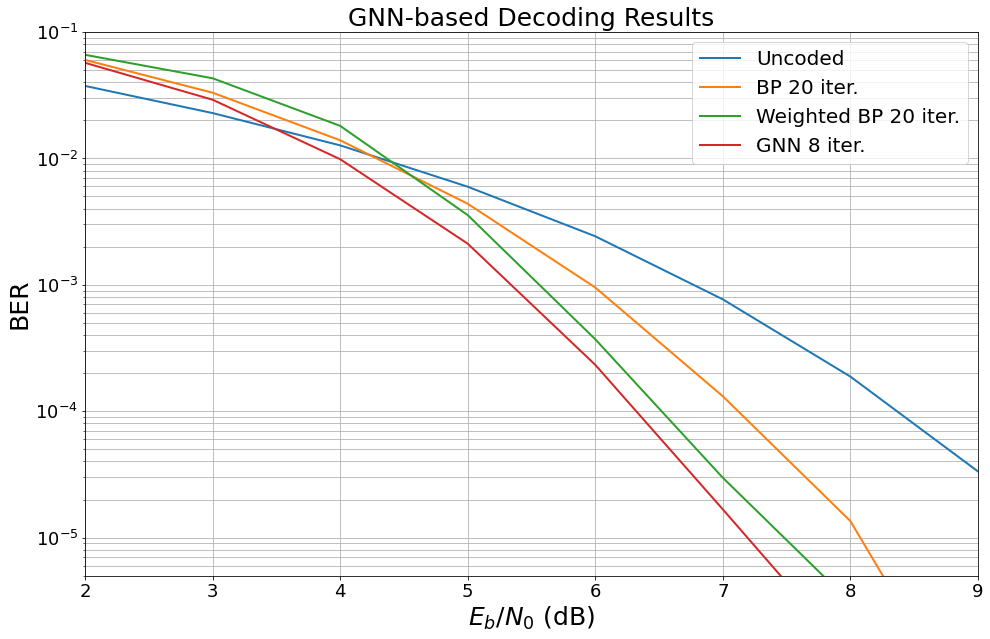

In [38]:
# and show the final performance
ber_plot(xlim=[2., 9.], ylim=[5e-6, 0.1])

As can be seen, the GNN-based decoder outperforms BP and WBP with significantly less iterations.

Please note that due to the limit the training time, the GNN is not perfectly trained for the BCH code. 
You can find a more sophisticated training in the same provided repository.

A few ideas to explore:
- Can you train the decoder for LDPC or Polar codes?
- What is the optimal NN architecture?
- Conceptually, non-binary decoders could be also learned within the same framework
- Can we get insights from the learned solution for improved *classical* decoding algorithms?

## References

[1] S. Cammerer, J. Hoydis, F. Aït Aoudia, and A. Keller, "Graph Neural Networks for Channel Decoding", 2022 https://arxiv.org/pdf/2207.14742.pdf

[2] V. G. Satorras, M. Welling, "Neural Enhanced Belief Propagation on Factor Graphs", International Conference on Artificial Intelligence and Statistics, pp. 685-693, 2021.

[3] E. Nachmani, Y. Be’ery and D. Burshtein, "Learning to Decode Linear Codes Using Deep Learning,"
IEEE Annual Allerton Conference on Communication, Control, and Computing (Allerton), pp. 341-346., 2016 https://arxiv.org/pdf/1607.04793.pdf